# Building ML Models for SRF Fault Classification
Chris Tennant <br>
_December 17, 2019_
***

Import `pandas`, `matplotlib`, `numpy` and `os` libraries.

In [1]:
                                                                                    import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import feather

dir = Path('C:/Users/tennant/Desktop/rfw_tsf_extractor-Spring-2018/extracted')

Read in .csv files with features computed by `tsfresh`.

In [2]:
y_master = pd.read_csv(dir/'y_fault_master.csv')

In [3]:
X_master = pd.read_csv(dir/'X_fault_master.csv')

In [4]:
y_master = y_master.drop(columns=['zone', 'time'])

In [5]:
X_master = X_master.drop(columns=['zone', 'time'])

In [6]:
print("Number of training examples: {}".format(X_master.shape[0]))
print("Number of features: {}".format(X_master.shape[1]))
print("Number of categories: {}".format(y_master['label'].nunique()))

Number of training examples: 330
Number of features: 12818
Number of categories: 4


Histogram showing how the distribution of the types of faults in the data set.

In [7]:
y_master['label'].value_counts()

Single Cav Turn off    140
Quench                 114
Microphonics            50
E_Quench                26
Name: label, dtype: int64

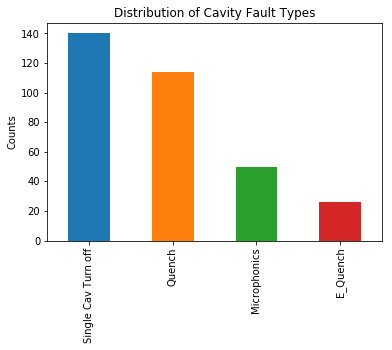

In [8]:
#y_master.T.head(55)
y_master['label'].value_counts().plot(kind='bar');
plt.title("Distribution of Cavity Fault Types");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

Use `impute` from `tsfresh` to replace all `NaNs` and `infs` from the `DataFrame` with average/extreme values from the same columns.

In [9]:
from tsfresh.utilities.dataframe_functions import impute

X_master = impute(X_master)

Need to convert categorical labels to numeric labels using `LabelEncoder`.

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_master_encoded = pd.Series(le.fit_transform(np.ravel(y_master)), y_master.index)
np.save('le_fault_classes.npy', le.classes_)

Split the data into training and test sets using `train_test_split` from `sklearn`. Keep 30% of the data for testing.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_master, y_master_encoded, test_size = 0.3, random_state=123, stratify=y_master)

In [12]:
print("The number of training examples is: {}".format(X_train.shape[0]))
print("The number of test examples is: {}".format(X_test.shape[0]))

The number of training examples is: 231
The number of test examples is: 99


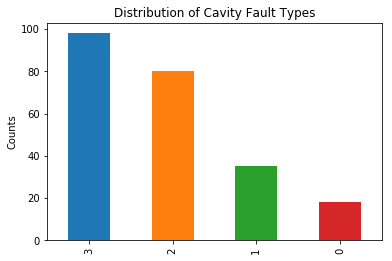

In [13]:
y_train.value_counts().plot(kind='bar');
plt.title("Distribution of Cavity Fault Types");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

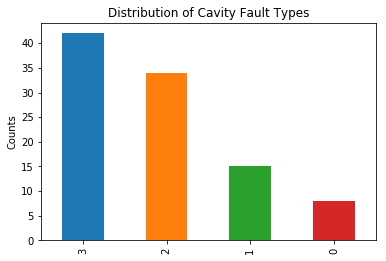

In [14]:
y_test.value_counts().plot(kind='bar');
plt.title("Distribution of Cavity Fault Types");
plt.ylabel("Counts");
#plt.savefig("faults_bar.png", bbox_inches = "tight", dpi=200)

Need to standardize features by removing the mean and scaling to unit variance. Note to avoid _data leak_ we standardize the training data and then use the same step (including the same values for mean and standard deviation) on the test set.
<br><br>
_(Note, it may be wise to standardize the initial time-series signals before computing features. However, it requires having all the data together in a single `DataFrame`. Due to computational issues with `tsfresh`, this is not possible and need to compute small batches of data at a time)._

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

Save (mean, variance) values as `numpy` arrays for use with saved model when deployed.

In [16]:
X_train_mean = sc.fit(X_train).mean_
X_train_var = sc.fit(X_train).scale_

np.save('RF_FAULT_mean', X_train_mean, allow_pickle=False)
np.save('RF_FAULT_var', X_train_var, allow_pickle=False)

Import libraries containing performance metrics and models.

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from matplotlib import pyplot

Evaluate models using code from *"Machine Learning Mastery with Python"*.<br>
Model performance is evaluated using _k_-folds cross-validation, so the test set remains untouched.

In [22]:
# prepare models
models = []
#non-linear models
models.append(('KNN', KNeighborsClassifier(n_neighbors=4)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('BAYES', GaussianNB()))
# ensemble models
models.append(('BAG', BaggingClassifier(n_estimators=100)))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('XT', ExtraTreesClassifier(n_estimators=100)))
models.append(('GBM', GradientBoostingClassifier(n_estimators=100)))
#models.append(('AB', AdaBoostClassifier(n_estimators=100)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, X_train_scaled, np.ravel(y_train), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.839778 (0.057792)
DT: 0.809436 (0.094806)
SVC: 0.900555 (0.046479)
BAYES: 0.818316 (0.115261)
BAG: 0.926642 (0.050094)
RF: 0.956892 (0.030225)
XT: 0.948196 (0.040006)
GBM: 0.935153 (0.038688)


In [23]:
np.save('FAULT_CV_results', results, allow_pickle=False)
names

['KNN', 'DT', 'SVC', 'BAYES', 'BAG', 'RF', 'XT', 'GBM']

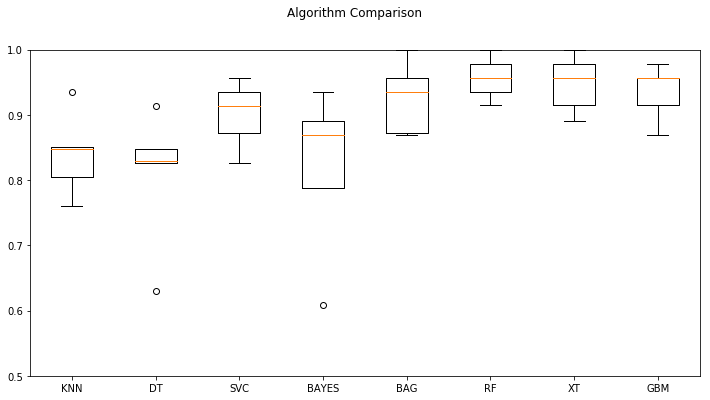

In [24]:
# boxplot algorithm comparison
fig = pyplot.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.ylim((0.5,1))
pyplot.show()

Choose the `RandomForest` for its performance and also robustness against overfitting. Use `GridSearch` to perform hyperparameter tuning.

In [25]:
from sklearn.model_selection import GridSearchCV
parameter_candidates = {'n_estimators': np.arange(25,250,25), 'min_samples_split': np.arange(2,18,1), 'max_depth': np.arange(2,18,1)}

In [26]:
# create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, verbose=1, cv=5)

# train the classifier 
%time clf.fit(X_train_scaled, np.ravel(y_train)) 

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11520 out of 11520 | elapsed: 97.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 1h 37min 23s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [27]:
# view the accuracy score
print('Best accuracy score for training data:', clf.best_score_) 

# view the best parameters for the model found using grid search
print('Best min_samples_split:', clf.best_estimator_.min_samples_split)
print('Best max_depth:', clf.best_estimator_.max_depth)
print('Best n_estimators:', clf.best_estimator_.n_estimators)

Best accuracy score for training data: 0.9696969696969697
Best min_samples_split: 5
Best max_depth: 5
Best n_estimators: 125


Use the best parameters to define the model.

In [28]:
RF_model = RandomForestClassifier(n_estimators=125, max_depth=5, min_samples_split=5, max_features=None, random_state=11)
RF_model.fit(X_train_scaled, np.ravel(y_train))
print(RF_model.score(X_test_scaled, np.ravel(y_test)))

0.8787878787878788


In [18]:
y_test.value_counts()

3    42
2    34
1    15
0     8
dtype: int64

Save final `RandomForestClassifier` model using `joblib` (more [here](https://chrisalbon.com/machine_learning/basics/saving_machine_learning_models/)). Note, this model has been trained on *ALL* the features.

In [30]:
# save model using joblib
from sklearn.externals import joblib
from sklearn.externals import joblib

filename_joblib = 'RF_FAULT_12172019_TMP.sav'
#joblib.dump(RF_model, filename_joblib)

# save model using pickle
from pickle import dump
from pickle import load

filename_pickle = 'RF_FAULT.pkl'
#dump(RF_model, open(filename_pickle, 'wb'))

Having trained a good `RandomForestClassifier`, need to compute the top *N* features.

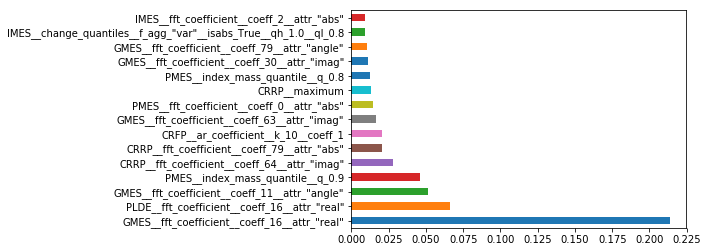

In [31]:
feat_importances = pd.Series(RF_model.fit(X_train_scaled, np.ravel(y_train)).feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [32]:
RF_top50 = [feat_importances.nlargest(50).index[x] for x in range(50)]
RF_top50

['GMES__fft_coefficient__coeff_16__attr_"real"',
 'PLDE__fft_coefficient__coeff_16__attr_"real"',
 'GMES__fft_coefficient__coeff_11__attr_"angle"',
 'PMES__index_mass_quantile__q_0.9',
 'CRRP__fft_coefficient__coeff_64__attr_"imag"',
 'CRRP__fft_coefficient__coeff_79__attr_"abs"',
 'CRFP__ar_coefficient__k_10__coeff_1',
 'GMES__fft_coefficient__coeff_63__attr_"imag"',
 'PMES__fft_coefficient__coeff_0__attr_"abs"',
 'CRRP__maximum',
 'PMES__index_mass_quantile__q_0.8',
 'GMES__fft_coefficient__coeff_30__attr_"imag"',
 'GMES__fft_coefficient__coeff_79__attr_"angle"',
 'IMES__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
 'IMES__fft_coefficient__coeff_2__attr_"abs"',
 'PLDE__minimum',
 'PLDE__fft_coefficient__coeff_28__attr_"real"',
 'IMES__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
 'CRRP__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
 'DFQES__fft_coefficient__coeff_52__attr_"abs"',
 'CRRP__approximate_entropy__m_2__r_0.5',
 'CRRP__fft_coeff

In [19]:
RF_top50=['GMES__fft_coefficient__coeff_16__attr_"real"',
 'PLDE__fft_coefficient__coeff_16__attr_"real"',
 'GMES__fft_coefficient__coeff_11__attr_"angle"',
 'PMES__index_mass_quantile__q_0.9',
 'CRRP__fft_coefficient__coeff_64__attr_"imag"',
 'CRRP__fft_coefficient__coeff_79__attr_"abs"',
 'CRFP__ar_coefficient__k_10__coeff_1',
 'GMES__fft_coefficient__coeff_63__attr_"imag"',
 'PMES__fft_coefficient__coeff_0__attr_"abs"',
 'CRRP__maximum',
 'PMES__index_mass_quantile__q_0.8',
 'GMES__fft_coefficient__coeff_30__attr_"imag"',
 'GMES__fft_coefficient__coeff_79__attr_"angle"',
 'IMES__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
 'IMES__fft_coefficient__coeff_2__attr_"abs"',
 'PLDE__minimum',
 'PLDE__fft_coefficient__coeff_28__attr_"real"',
 'IMES__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
 'CRRP__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
 'DFQES__fft_coefficient__coeff_52__attr_"abs"',
 'CRRP__approximate_entropy__m_2__r_0.5',
 'CRRP__fft_coefficient__coeff_29__attr_"abs"',
 'CRRP__fft_coefficient__coeff_48__attr_"imag"',
 'DFQES__ratio_value_number_to_time_series_length',
 'PMES__number_peaks__n_5',
 'PMES__energy_ratio_by_chunks__num_segments_10__segment_focus_5',
 'PLDE__fft_coefficient__coeff_49__attr_"angle"',
 'IMES__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'CRRP__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"intercept"',
 'GASK__ar_coefficient__k_10__coeff_1',
 'CRRP__fft_coefficient__coeff_75__attr_"angle"',
 'IASK__fft_coefficient__coeff_45__attr_"abs"',
 'DETA2__number_peaks__n_3',
 'CRFPP__percentage_of_reoccurring_values_to_all_values',
 'CRRP__fft_coefficient__coeff_64__attr_"angle"',
 'GMES__fft_coefficient__coeff_28__attr_"real"',
 'CRRP__fft_coefficient__coeff_31__attr_"abs"',
 'CRRP__fft_coefficient__coeff_96__attr_"imag"',
 'GASK__ratio_beyond_r_sigma__r_10',
 'PLDE__fft_coefficient__coeff_33__attr_"real"',
 'CRRP__fft_coefficient__coeff_33__attr_"abs"',
 'CRRP__standard_deviation',
 'GMES__spkt_welch_density__coeff_5',
 'CRRP__fft_coefficient__coeff_76__attr_"abs"',
 'PLDE__fft_coefficient__coeff_17__attr_"abs"',
 'DFQES__fft_coefficient__coeff_51__attr_"abs"',
 'CRFP__time_reversal_asymmetry_statistic__lag_1',
 'DFQES__fft_coefficient__coeff_50__attr_"real"',
 'IMES__linear_trend__attr_"rvalue"',
 'PMES__energy_ratio_by_chunks__num_segments_10__segment_focus_9']

In [20]:
X_train_scaled_top50 = X_train_scaled[RF_top50]
X_test_scaled_top50 = X_test_scaled[RF_top50]

In [21]:
X_train_scaled_top50.shape, X_test_scaled_top50.shape, y_train.shape, y_test.shape

((231, 50), (99, 50), (231,), (99,))

In [22]:
a = list(X_train_scaled_top50.columns)
b = list(X_test_scaled_top50.columns)
print(a == b)

True


In [23]:
X_train_scaled_top50.to_csv('X_fault_train_scaled_top50.csv')
y_train.to_csv('y_fault_train.csv')
X_test_scaled_top50.to_csv('X_fault_test_scaled_top50.csv')
y_test.to_csv('y_fault_test.csv')

In [24]:
test = pd.read_csv('X_fault_train_scaled_top50.csv')

In [25]:
test.head()

,Unnamed: 0,"GMES__fft_coefficient__coeff_16__attr_""real""","PLDE__fft_coefficient__coeff_16__attr_""real""","GMES__fft_coefficient__coeff_11__attr_""angle""",PMES__index_mass_quantile__q_0.9,"CRRP__fft_coefficient__coeff_64__attr_""imag""","CRRP__fft_coefficient__coeff_79__attr_""abs""",CRFP__ar_coefficient__k_10__coeff_1,"GMES__fft_coefficient__coeff_63__attr_""imag""","PMES__fft_coefficient__coeff_0__attr_""abs""",...,"CRRP__fft_coefficient__coeff_33__attr_""abs""",CRRP__standard_deviation,GMES__spkt_welch_density__coeff_5,"CRRP__fft_coefficient__coeff_76__attr_""abs""","PLDE__fft_coefficient__coeff_17__attr_""abs""","DFQES__fft_coefficient__coeff_51__attr_""abs""",CRFP__time_reversal_asymmetry_statistic__lag_1,"DFQES__fft_coefficient__coeff_50__attr_""real""","IMES__linear_trend__attr_""rvalue""",PMES__energy_ratio_by_chunks__num_segments_10__segment_focus_9
0,121,0.944140,-0.945822,-0.571573,-0.456273,-0.915456,-0.515893,-1.851807,-1.275763,1.797629,...,-0.400720,-0.722057,-0.497111,-0.588638,-0.152705,-0.764556,0.002563,-0.039950,1.375137,-0.695581
1,305,-1.933479,1.805509,2.036245,-0.041166,1.771568,0.153904,0.870173,1.513172,-0.143594,...,0.643408,0.743607,-0.326897,0.514710,1.693817,0.655756,0.007198,0.218160,-0.157215,-0.267577
2,79,0.333563,-0.356297,-0.395181,-0.465043,-0.146850,0.554604,0.663358,0.247009,0.836680,...,-0.311989,-0.406083,0.023278,0.273114,-0.910231,-0.020368,0.005585,-1.313188,0.780169,-0.585223
3,85,0.588786,-0.599067,-0.444755,0.660423,-0.630408,-0.696037,-0.653876,-0.458208,0.343610,...,-0.845446,-0.737205,-0.198013,-0.783526,-1.202018,-0.707056,0.003498,-0.144114,-0.368715,0.167634
4,307,-1.959233,1.830222,1.987527,-0.032397,1.565341,-0.227540,0.613107,1.407932,-0.144442,...,0.678254,0.759957,-0.265326,0.512883,1.712746,0.515904,0.007924,0.100418,-0.146118,-0.268508


In [26]:
y_train.head()

121    3
305    2
79     2
85     3
307    2
dtype: int32